# Importing Necessary Libraries

In [61]:
# import data handling tools
import cv2
import os
import shutil
import pathlib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import glob
import PIL
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import datetime as dt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### Read Data

In [2]:
Random_image_Path = '/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final/ain/AIN (1).JPG'

In [3]:
def Get_Image_Info(image_Path):
    
    # Get the file size in bytes
    file_size = os.path.getsize(image_Path)
    print(f"File size: {file_size} bytes" , "\n")
    
    image = PIL.Image.open(image_Path)
    # Get the image format and type
    image_format = image.format
    image_type = image.mode
    print(f"Image format: {image_format}")
    print(f"Image type: {image_type}", "\n")
    
    image_shape = image.size
    print(f"Image shape: {image_shape} pixels", "\n")

In [4]:
Get_Image_Info(Random_image_Path)

File size: 803 bytes 

Image format: JPEG
Image type: L 

Image shape: (64, 64) pixels 



File size: 5642 bytes 

Image format: JPEG
Image type: L 

Image shape: (64, 64) pixels 



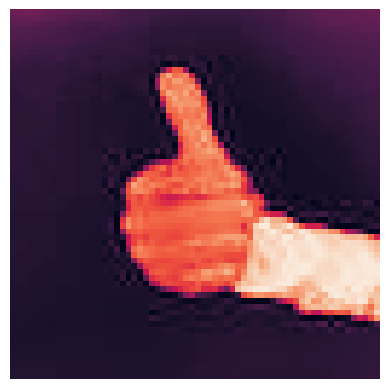

In [5]:
img_path = '/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final/aleff/Aleff (1).JPG'
Get_Image_Info(img_path)
import matplotlib.pyplot as plt
img = Image.open(img_path)
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

### From this, we can infer that the images in grayscale
### and it’s shape is small , so now we need to resize images 

# Resize the images

In [6]:
# Define the base path where your Images folders are located
base_path = "/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final"

In [7]:
target_size=(128,128)
def resize_image(image_path, output_path):
    with Image.open(image_path) as img:
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img.save(output_path)

In [8]:
os.makedirs('/kaggle/working/test', exist_ok=True)

In [9]:
# Try the function
random_image_path = '/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final/dha/DHA (1).JPG'
resize_image(random_image_path , '/kaggle/working/test.jpg')

In [10]:
Get_Image_Info('/kaggle/working/test.jpg')

File size: 1534 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



In [11]:
def process_images_in_directory(input_dir, output_dir):
    """Iterate over all images in the input directory and its subdirectories,
    apply resizing, and save them to a corresponding structure in the output directory."""
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                resize_image(input_path, output_path)

                
input_directory = '/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final'
output_directory = '/kaggle/working/resized_images'
process_images_in_directory(input_directory, output_directory)

# check the info of new images 

In [12]:
import random

def find_all_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [13]:
def display_random_images(image_paths, num_images=10):
    if len(image_paths) < num_images:
        print(f"Only {len(image_paths)} images found, displaying them all.")
        selected_images = image_paths
    else:
        selected_images = random.sample(image_paths, num_images)
    
    for img_path in selected_images:
        Get_Image_Info(img_path)
        img = Image.open(img_path)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print('--------------------------------------------------------------')

In [14]:
output_directory = '/kaggle/working/resized_images'
image_paths = find_all_images(output_directory)
print(f"Total number of images: {len(image_paths)}")

Total number of images: 54049


File size: 1473 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



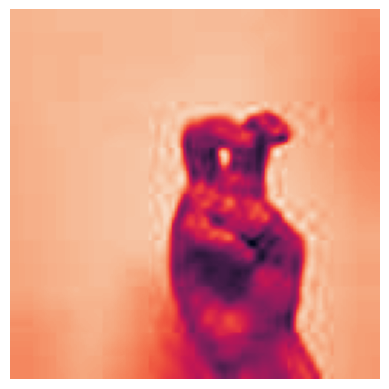

--------------------------------------------------------------
File size: 1456 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



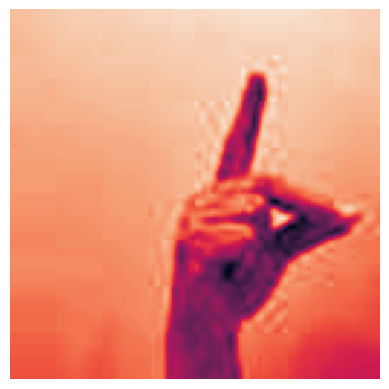

--------------------------------------------------------------
File size: 1639 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



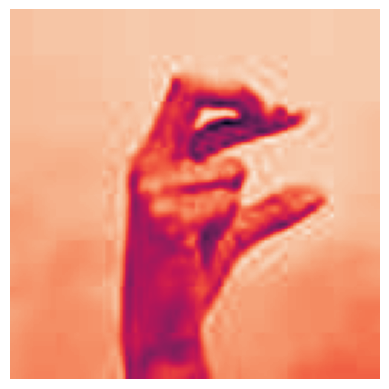

--------------------------------------------------------------
File size: 1560 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



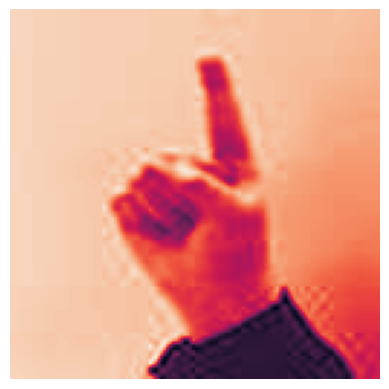

--------------------------------------------------------------
File size: 1190 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



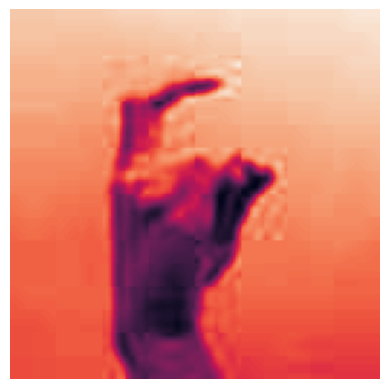

--------------------------------------------------------------
File size: 1915 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



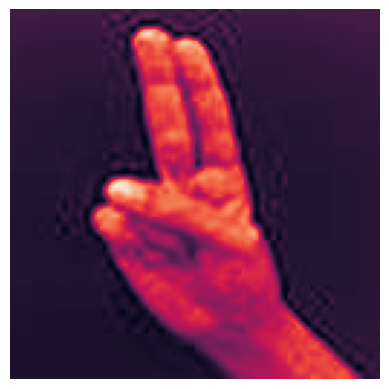

--------------------------------------------------------------
File size: 1314 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



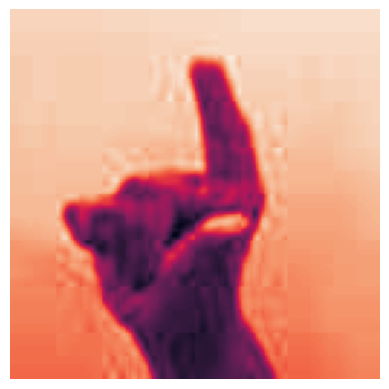

--------------------------------------------------------------
File size: 1547 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



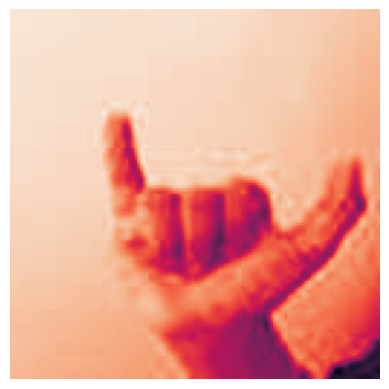

--------------------------------------------------------------
File size: 1448 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



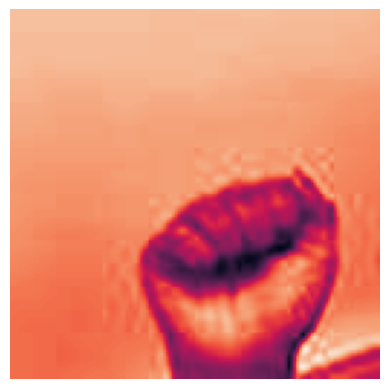

--------------------------------------------------------------
File size: 1217 bytes 

Image format: JPEG
Image type: L 

Image shape: (128, 128) pixels 



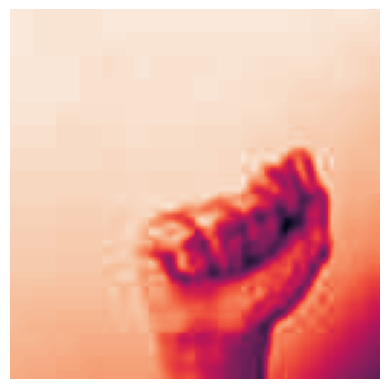

--------------------------------------------------------------


In [15]:
display_random_images(image_paths, 10)

### Store data in dataframe

In [16]:
# Generate data paths with labels
data_dir = '/kaggle/working/resized_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
# print (folds)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df= pd.concat([Fseries, Lseries], axis= 1)

In [17]:
df

,filepaths,labels
0,/kaggle/working/resized_images/nun/Nun (937).jpg,nun
1,/kaggle/working/resized_images/nun/Nun (275).jpg,nun
2,/kaggle/working/resized_images/nun/Nun (1542).jpg,nun
3,/kaggle/working/resized_images/nun/Nun (255).jpg,nun
4,/kaggle/working/resized_images/nun/Nun (654).jpg,nun
...,...,...
54044,/kaggle/working/resized_images/jeem/JEEM (575)...,jeem
54045,/kaggle/working/resized_images/jeem/JEEM (777)...,jeem
54046,/kaggle/working/resized_images/jeem/JEEM (464)...,jeem
54047,/kaggle/working/resized_images/jeem/JEEM (528)...,jeem


In [18]:
df['labels'].nunique()

32

In [19]:
df['labels'].value_counts()

labels
ain      2114
ghain    1977
fa       1955
saad     1895
taa      1838
laam     1832
nun      1819
ta       1816
toot     1791
bb       1791
kaaf     1774
thaa     1766
meem     1765
la       1746
dha      1723
ya       1722
gaaf     1705
aleff    1672
dhad     1670
ra       1659
seen     1638
dal      1634
khaa     1607
ha       1592
thal     1582
jeem     1552
haa      1526
sheen    1507
zay      1374
waw      1371
al       1343
yaa      1293
Name: count, dtype: int64

### Split data into train, valid, and test

In [20]:
strat = df['labels']
train_df, tst_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = tst_df['labels']
valid_df, test_df = train_test_split(tst_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [21]:
train_df

,filepaths,labels
15556,/kaggle/working/resized_images/saad/SAAD (920)...,saad
36900,/kaggle/working/resized_images/ghain/GHAIN (62...,ghain
15012,/kaggle/working/resized_images/thaa/THAA (283)...,thaa
18979,/kaggle/working/resized_images/laam/LAAM (1465...,laam
34016,/kaggle/working/resized_images/kaaf/KAAF (1686...,kaaf
...,...,...
7673,/kaggle/working/resized_images/aleff/Aleff (40...,aleff
48506,/kaggle/working/resized_images/ain/AIN (358).JPG,ain
33168,/kaggle/working/resized_images/sheen/SHEEN (25...,sheen
16058,/kaggle/working/resized_images/saad/SAAD (1633...,saad


In [22]:
test_df

,filepaths,labels
33063,/kaggle/working/resized_images/sheen/SHEEN (10...,sheen
39056,/kaggle/working/resized_images/gaaf/GAAF (685)...,gaaf
21332,/kaggle/working/resized_images/al/AL (155).jpg,al
42703,/kaggle/working/resized_images/zay/ZAY (424).JPG,zay
15194,/kaggle/working/resized_images/thaa/THAA (1307...,thaa
...,...,...
43554,/kaggle/working/resized_images/zay/ZAY (793).jpg,zay
22910,/kaggle/working/resized_images/yaa/YAA (1147).jpg,yaa
2232,/kaggle/working/resized_images/ra/RA (1189).jpg,ra
50368,/kaggle/working/resized_images/taa/TAA (1731).jpg,taa


In [23]:
valid_df

,filepaths,labels
9140,/kaggle/working/resized_images/dha/DHA (379).jpg,dha
11659,/kaggle/working/resized_images/ta/TA (526).JPG,ta
53087,/kaggle/working/resized_images/jeem/JEEM (377)...,jeem
19076,/kaggle/working/resized_images/laam/LAAM (578)...,laam
27787,/kaggle/working/resized_images/seen/SEEN (1266...,seen
...,...,...
22264,/kaggle/working/resized_images/yaa/YAA (393).jpg,yaa
27607,/kaggle/working/resized_images/seen/SEEN (1587...,seen
50989,/kaggle/working/resized_images/ha/HA (549).jpg,ha
8381,/kaggle/working/resized_images/dha/DHA (682).jpg,dha


### Create image data generator¶

In [31]:
# crobed image size
batch_size = 64
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 43239 validated image filenames belonging to 32 classes.
Found 5405 validated image filenames belonging to 32 classes.
Found 5405 validated image filenames belonging to 32 classes.


### Show sample from train data

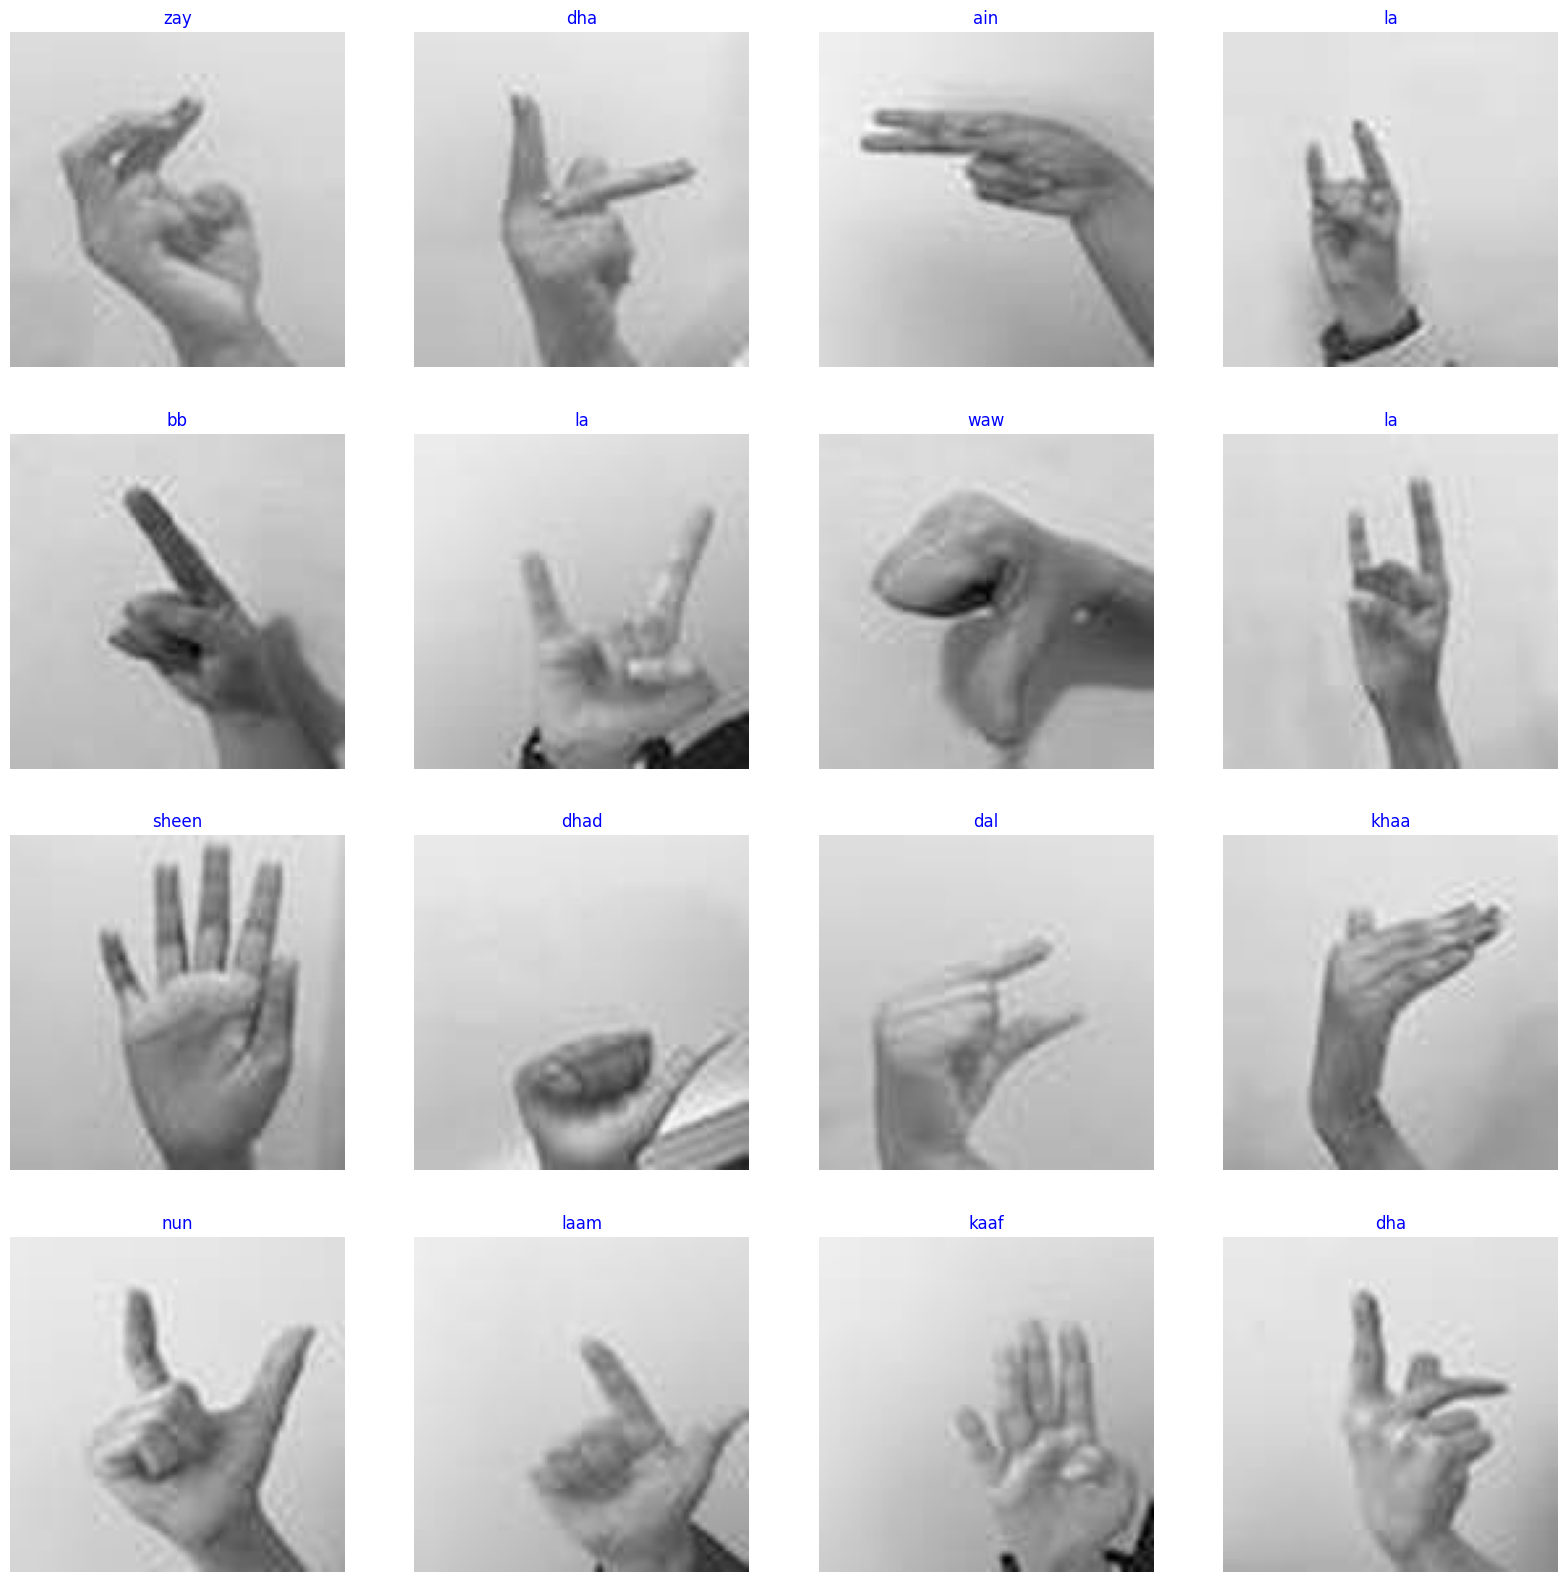

In [25]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

- Generic Model Creation

In [32]:
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])



In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                 

In [44]:
model.compile(Adamax(learning_rate= 0.001), 
              loss= 'categorical_crossentropy', 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [35]:
print(dt.datetime.now())

2024-03-23 08:49:42.344419


### Train model

In [63]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs,
                    verbose= 1,validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/50
676/676 [==============================] - 96s 142ms/step - loss: 0.0538 - accuracy: 0.9843 - precision: 0.9885 - recall: 0.9819 - val_loss: 0.1469 - val_accuracy: 0.9632 - val_precision: 0.9738 - val_recall: 0.9611
Epoch 2/50
676/676 [==============================] - 96s 142ms/step - loss: 0.0479 - accuracy: 0.9865 - precision: 0.9896 - recall: 0.9846 - val_loss: 0.1915 - val_accuracy: 0.9582 - val_precision: 0.9678 - val_recall: 0.9558
Epoch 3/50
676/676 [==============================] - 96s 142ms/step - loss: 0.0438 - accuracy: 0.9871 - precision: 0.9895 - recall: 0.9858 - val_loss: 0.1864 - val_accuracy: 0.9567 - val_precision: 0.9684 - val_recall: 0.9530
Epoch 4/50
676/676 [==============================] - 96s 142ms/step - loss: 0.0443 - accuracy: 0.9875 - precision: 0.9896 - recall: 0.9862 - val_loss: 0.1530 - val_accuracy: 0.9637 - val_precision: 0.9759 - val_recall: 0.9608
Epoch 5/50
676/676 [==============================] - 96s 142ms/step - loss: 0.0295 - accura

In [65]:
print(dt.datetime.now())

2024-03-23 10:34:35.349965


### Display model performance

In [66]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

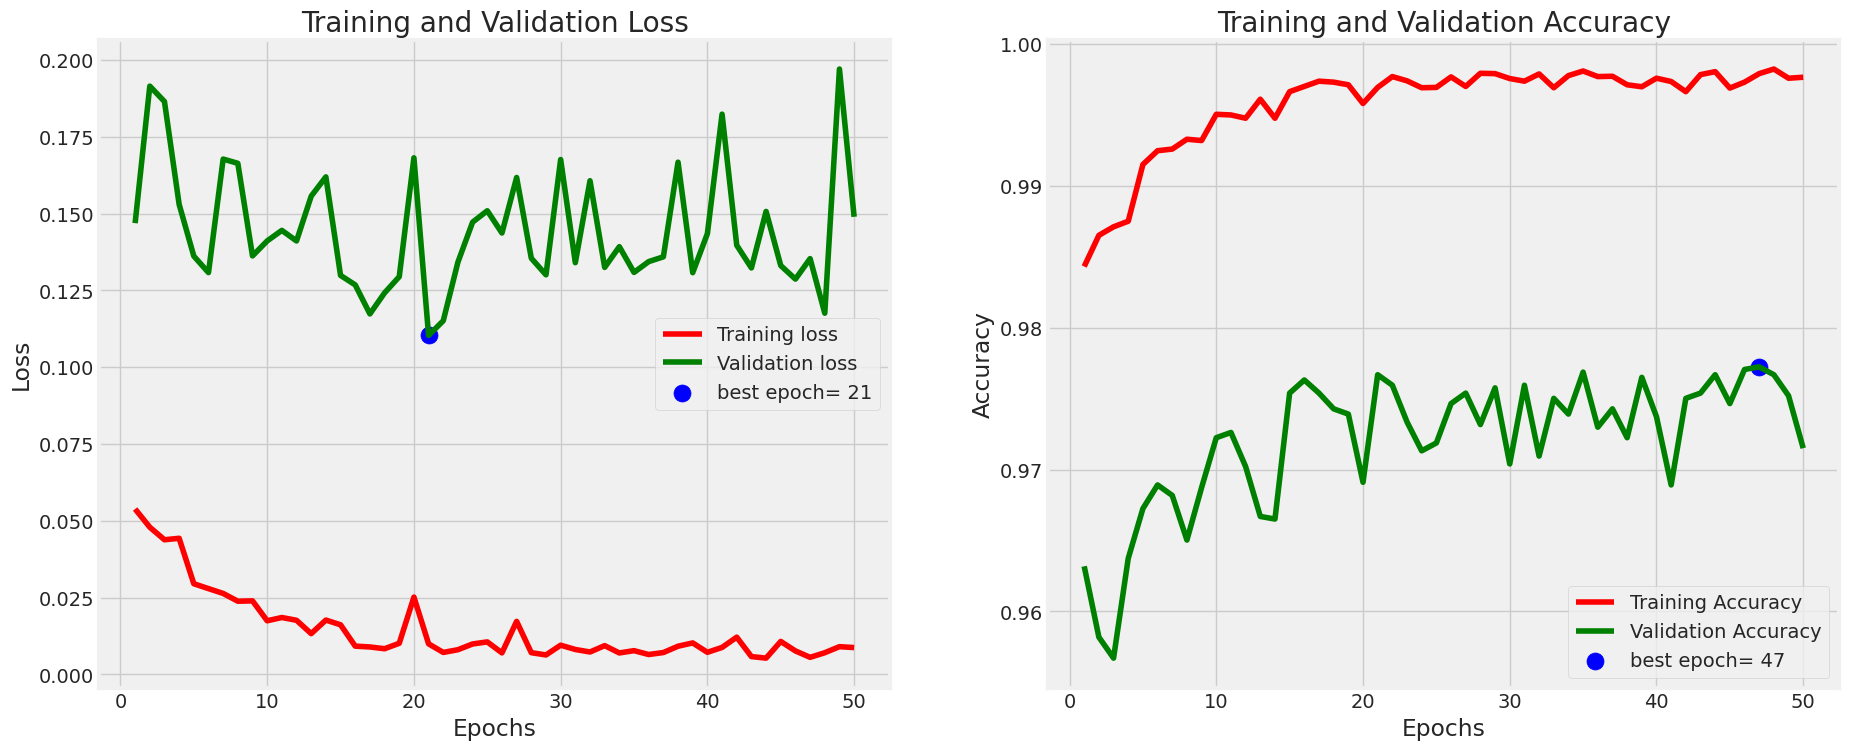

In [67]:
plot_training(history)

In [68]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming test_gen is your testing dataset generator
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
predictions = model.predict(test_gen, steps=test_steps_per_epoch)
# Convert predictions to one hot vectors
predicted_classes = np.argmax(predictions, axis=1)
# Get true labels
true_classes = test_gen.classes


85/85 [==============================] - 4s 43ms/step


In [69]:
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# True negatives are at cm[0][0], True positives are at cm[1][1]
# False negatives are at cm[1][0], False positives are at cm[0][1]

cm


array([[211,   0,   0, ...,   0,   0,   0],
       [  0, 133,   0, ...,   0,   0,   0],
       [  0,   0, 162, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 171,   0,   0],
       [  0,   0,   0, ...,   0, 127,   0],
       [  0,   1,   0, ...,   0,   0, 127]])

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 7) , p = True):  # Add figsize parameter with a default value
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)  # Set the figure size here

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # OPTIONAL: Fill in the cells with confusion matrix counts
    if p: 
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


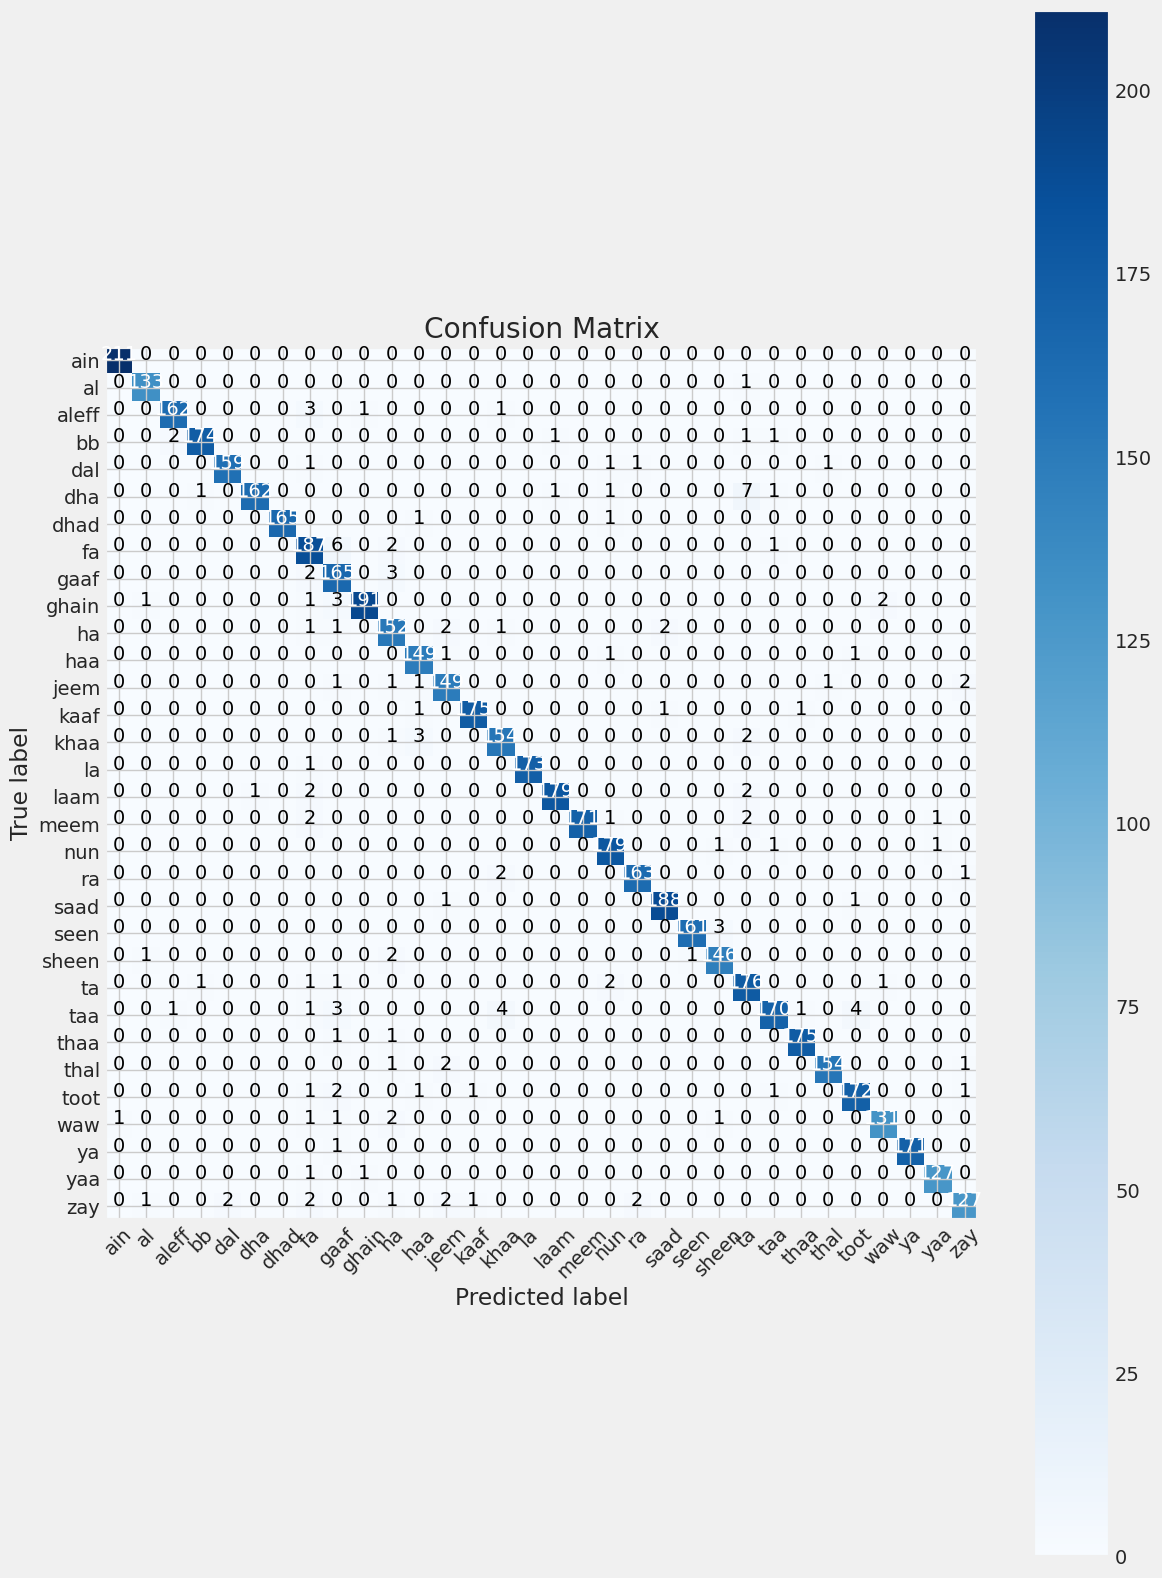

In [82]:
class_labels = list(test_gen.class_indices.keys())
# Assuming cm is your confusion matrix and class_labels contains your labels
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix' , figsize=(12, 16))


Confusion matrix, without normalization


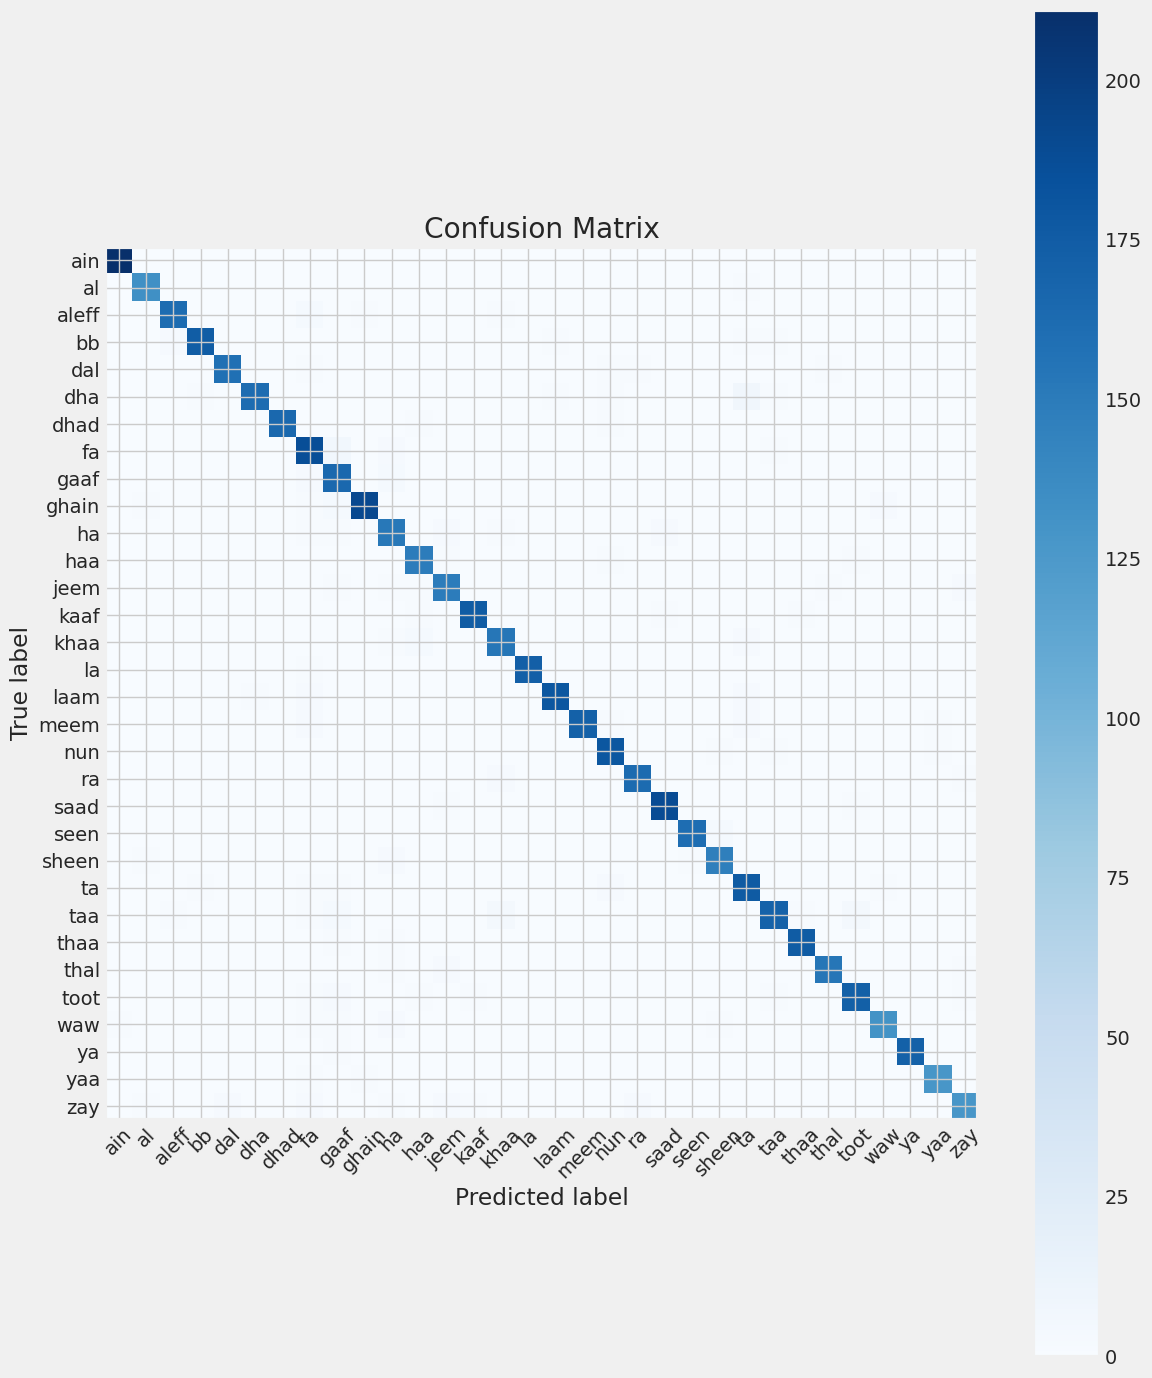

In [84]:
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix' ,  figsize=(12, 14) , p = False )

Normalized confusion matrix


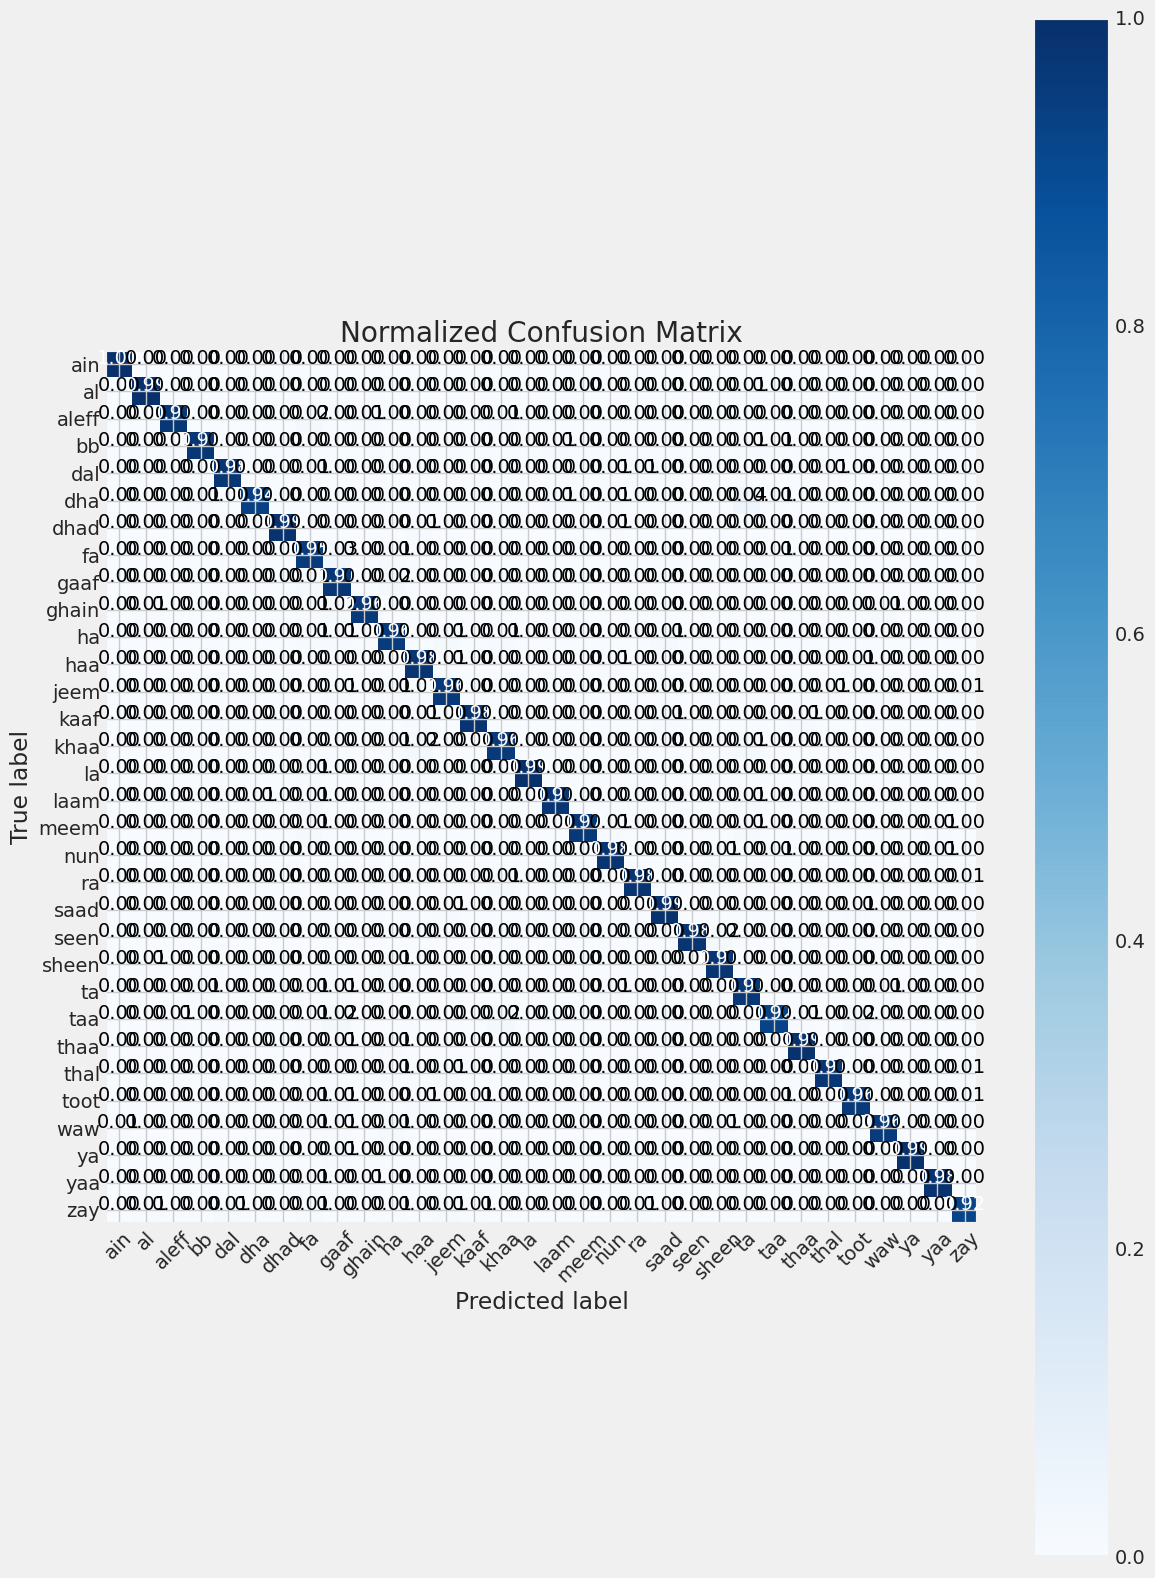

In [86]:
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix' , figsize=(12, 16))


Normalized confusion matrix


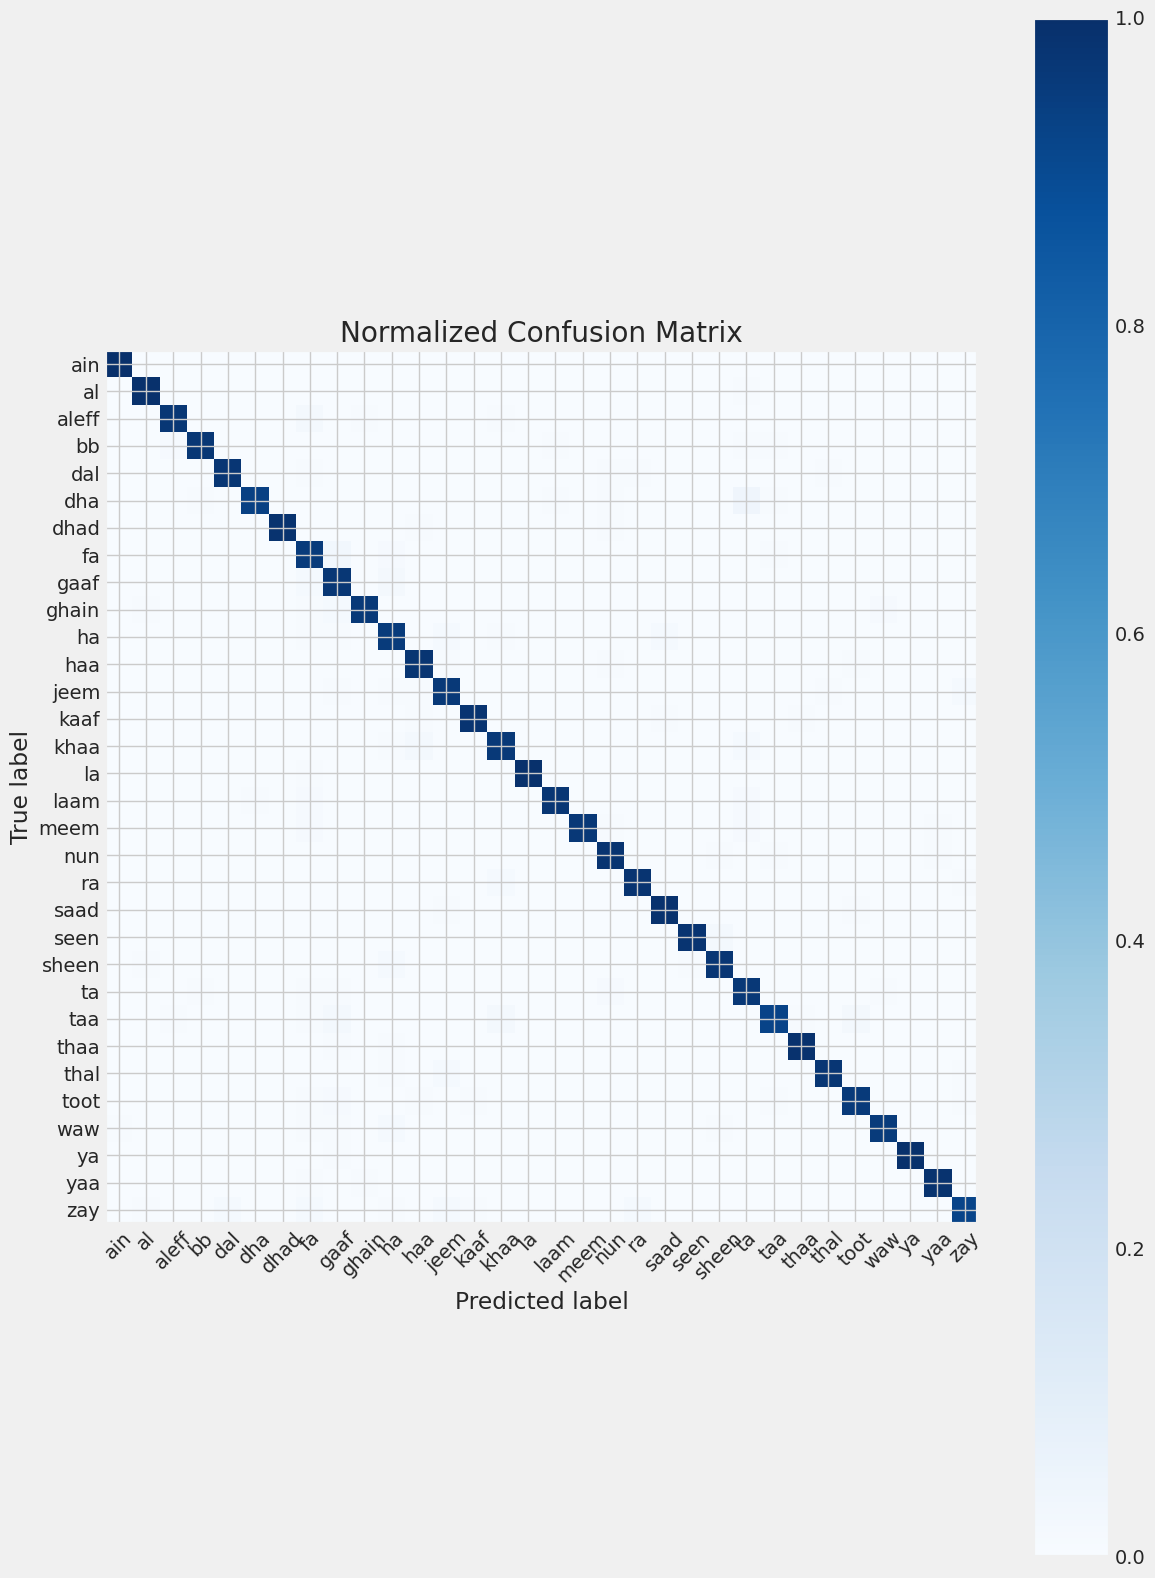

In [87]:
plot_confusion_matrix(cm, classes=class_labels, normalize=True, p = False, title='Normalized Confusion Matrix' , figsize=(12, 16))

In [134]:
#  (None, 'micro', 'macro', 'weighted', 'samples') 
# Calculating Sensitivity (Recall)
sensitivity = recall_score(true_classes, predicted_classes, average='micro')

# Calculating Specificity
specificity = cm[0][0] / (cm[0][0] + cm[0][1])

# Other metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='micro')
f1 = f1_score(true_classes, predicted_classes, average='micro')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nF1 Score: {f1}\nSensitivity: {sensitivity}\nSpecificity: {specificity}")

Accuracy: 0.9715078630897317
Precision: 0.9715078630897317
F1 Score: 0.9715078630897317
Sensitivity: 0.9715078630897317
Specificity: 1.0


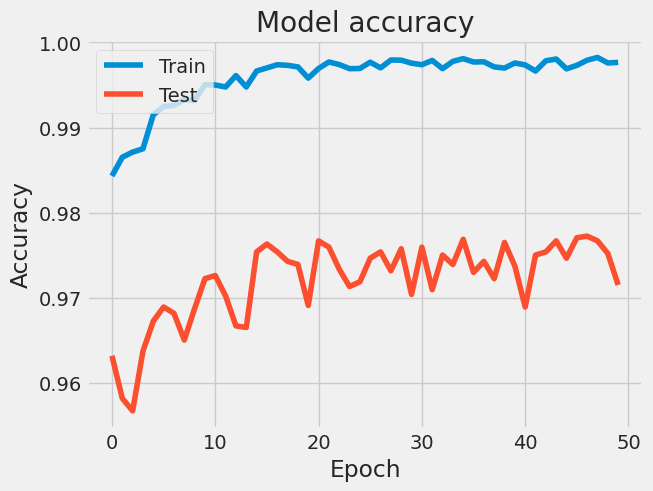

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

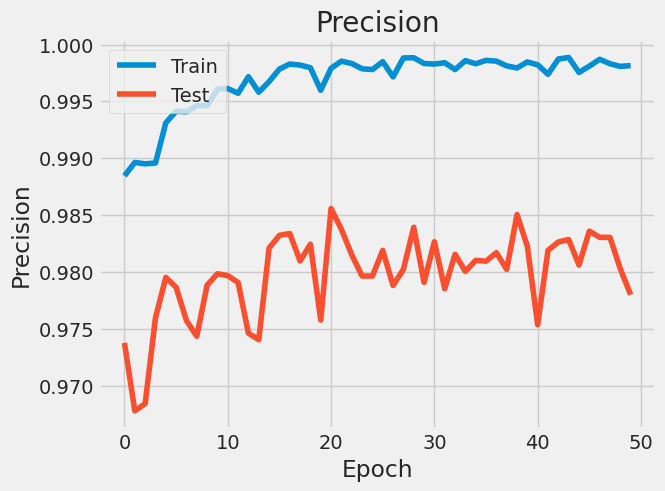

In [89]:
# Plot training & validation precision values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


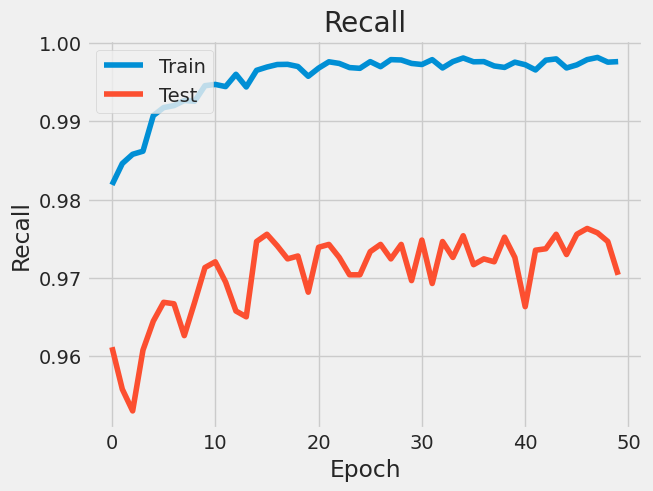

In [90]:
# Plot training & validation recall values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions

In [91]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[22  8  1 ... 14  7 14]


In [125]:
from tensorflow.keras.preprocessing import image
import numpy as np

image_path = '/kaggle/input/arasl-database/ArASL_Database_54K_Final/ArASL_Database_54K_Final/gaaf/GAAF (1).JPG'

img = image.load_img(image_path, target_size=(128, 128))

img_array = image.img_to_array(img)  # if your model expects images to be scaled between 0 and 1

# Add a new axis to make the image array compatible with the model input,
# converting it from (128, 128, 3) to (1, 128, 128, 3)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

# Assuming a softmax activation on the last layer, the 'predictions' will be
# a 2D numpy array with the probability of each class.
# You can get the index of the most probable class using 'argmax'.
predicted_class_index = np.argmax(predictions)

# If you have a mapping from class indices to class names, you can get the predicted class name:
class_labels = {v: k for k, v in train_gen.class_indices.items()}  # Reverse the mapping from 'train_gen.class_indices'
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

1/1 [==============================] - 0s 20ms/step
gaaf


## Save the model

In [105]:
from keras.models import load_model
model.save('/kaggle/working/KerasModel.h5')
model.save_weights('/kaggle/working/KerasModelWeigths.h5')

In [129]:
loaded_model = tf.keras.models.load_model('/kaggle/working/KerasModel.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
image_path = '/kaggle/working/resized_images/toot/TOOT (165).jpg'
image = Image.open(image_path).convert('RGB')
# Preprocess the image
img = image.resize((128, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['ain','ghain','fa','saad','taa','laam','nun','ta','toot','bb','kaaf','thaa',
                'meem','la','dha','ya','gaaf','aleff','dhad','ra','seen','dal','khaa','ha',
                'thal','jeem','haa','sheen','zay','waw','al','yaa']


score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 172ms/step
toot
